In [1]:
'''
city: city this user signed up in
phone: primary device for this user
signup_date: date of account registration; in the form `YYYYMMDD`
last_trip_date: the last time this user completed a trip; in the form `YYYYMMDD`
avg_dist: the average distance (in miles) per trip taken in the first 30 days after signup
avg_rating_by_driver: the rider’s average rating over all of their trips
avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
surge_pct: the percent of trips taken with surge multiplier > 1
avg_surge: The average surge multiplier over all of this user’s trips
trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
luxury_car_user: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise
weekday_pct: the percent of the user’s trips occurring during a weekday
'''

'\ncity: city this user signed up in\nphone: primary device for this user\nsignup_date: date of account registration; in the form `YYYYMMDD`\nlast_trip_date: the last time this user completed a trip; in the form `YYYYMMDD`\navg_dist: the average distance (in miles) per trip taken in the first 30 days after signup\navg_rating_by_driver: the rider\xe2\x80\x99s average rating over all of their trips\navg_rating_of_driver: the rider\xe2\x80\x99s average rating of their drivers over all of their trips\nsurge_pct: the percent of trips taken with surge multiplier > 1\navg_surge: The average surge multiplier over all of this user\xe2\x80\x99s trips\ntrips_in_first_30_days: the number of trips this user took in the first 30 days after signing up\nluxury_car_user: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise\nweekday_pct: the percent of the user\xe2\x80\x99s trips occurring during a weekday\n'

In [63]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
%matplotlib inline

/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
df = pd.read_csv('churn.csv')

In [26]:
df.head()
df.info()
df.phone.unique()
pd.value_counts(df['phone'].values)
df.avg_rating_of_driver.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


array([ 4.7,  5. ,  4.3,  4.6,  4.4,  3.5,  nan,  4.5,  4. ,  3.9,  4.9,
        4.8,  2.5,  3.7,  1. ,  4.1,  4.2,  3. ,  3.8,  2. ,  2.7,  3.3,
        2.8,  3.6,  3.4,  3.2,  2.6,  3.1,  2.9,  1.7,  1.8,  1.5,  2.3,
        1.9,  2.1,  2.4,  1.6,  2.2])

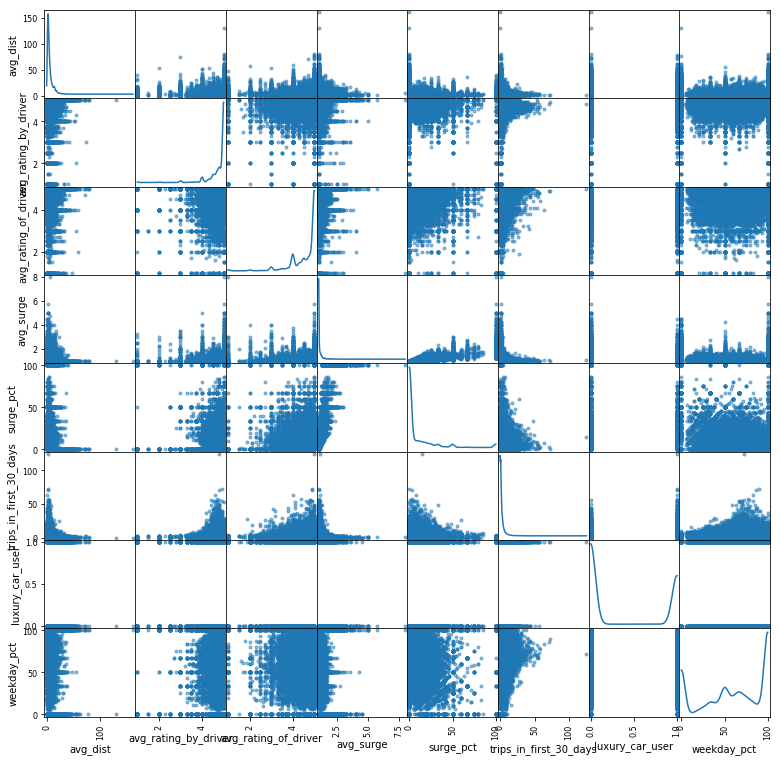

In [5]:
pd.scatter_matrix(df, diagonal='kde',figsize=(13,13))
plt.savefig('Churn_Scatter_Matrix.png',bbox_inches='tight')

In [6]:
plt.show()

In [168]:
#import data, create labels 

train = pd.read_csv('churn_train.csv',parse_dates = ['last_trip_date','signup_date'],infer_datetime_format=True)
test = pd.read_csv('churn_test.csv',parse_dates = ['last_trip_date','signup_date'],infer_datetime_format=True)
pulled_date = pd.to_datetime('2014-07-01')

train['days_since_last_trip'] =  (pulled_date - train['last_trip_date']).dt.days
test['days_since_last_trip'] = (pulled_date - test['last_trip_date']).dt.days 
train.head()
y_train_churn = (train['days_since_last_trip'].values > 30) * 1
y_test_churn = (test['days_since_last_trip'].values > 30) * 1 
#len(y_train_churn)
overall_churn_rate = float(sum(y_train_churn))/len(y_train_churn)
#overall_churn_rate = 0.6242

In [169]:
def is_weekend(data, columns):
    for col in columns:
        #weekend if day >= 5 (sat, sun)
        data[col+'_is_weekend']=data[col].dt.dayofweek >= 5
    return data

#add columns identifying whether signup date and last trip date were on weekends
train = is_weekend(train, columns = ['last_trip_date','signup_date'])
test = is_weekend(test, columns = ['last_trip_date','signup_date'])
#train.head()


In [170]:
#phone - dealing with null values 
train['phone'] = train['phone'].fillna('Other')
test['phone'] = test['phone'].fillna('Other')
#train.phone.unique()

#avg rating by driver - dealing with null values 
train['avg_rating_by_driver'] = train['avg_rating_by_driver'].fillna(train['avg_rating_by_driver'].mean())
test['avg_rating_by_driver'] = test['avg_rating_by_driver'].fillna(test['avg_rating_by_driver'].mean())

#avg rating of - dealing with null values 
train['avg_rating_of_driver']=[ by_driver if np.isnan(of_driver) else of_driver  for of_driver, by_driver in zip(train['avg_rating_of_driver'],train['avg_rating_by_driver'])]
test['avg_rating_of_driver']=[ by_driver if np.isnan(of_driver) else of_driver  for of_driver, by_driver in zip(test['avg_rating_of_driver'],test['avg_rating_by_driver'])]

#changing true, false to 1,0
train['luxury_car_user'] = train['luxury_car_user']*1
train['last_trip_date_is_weekend'] = train['last_trip_date_is_weekend']*1 
train['signup_date_is_weekend'] = train['signup_date_is_weekend']*1 
test['luxury_car_user'] = test['luxury_car_user']*1
test['last_trip_date_is_weekend'] = test['last_trip_date_is_weekend']*1 
test['signup_date_is_weekend'] = test['signup_date_is_weekend']*1 

train.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,last_trip_date_is_weekend,signup_date_is_weekend
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,0,100.0,59,1,1
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,1,0.0,156,1,1
2,21.50,4.0,4.0,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,1,100.0,41,0,0
3,9.46,5.0,5.0,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,0,100.0,172,0,0
4,13.77,5.0,5.0,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,0,100.0,49,0,0


In [171]:
#train.cities.unique()
#changing city and phone (object types / categorical) into dummies 
def make_dummies(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

train_new = make_dummies(train, columns=['city','phone'])
test_new = make_dummies(test, columns=['city','phone'])
train_new.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,last_trip_date_is_weekend,signup_date_is_weekend,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,6.94,5.0,5.0,1.00,2014-05-03,2014-01-12,0.0,0,0,100.0,59,1,1,1,0,0,1,0,0
1,8.06,5.0,5.0,1.00,2014-01-26,2014-01-25,0.0,2,1,0.0,156,1,1,1,0,0,1,0,0
2,21.50,4.0,4.0,1.00,2014-05-21,2014-01-02,0.0,1,1,100.0,41,0,0,0,0,1,0,0,1
3,9.46,5.0,5.0,2.75,2014-01-10,2014-01-09,100.0,1,0,100.0,172,0,0,0,0,1,1,0,0
4,13.77,5.0,5.0,1.00,2014-05-13,2014-01-31,0.0,0,0,100.0,49,0,0,0,0,1,0,0,1


In [172]:
#without last_trip_date, signup date
train2 = train_new.drop(['last_trip_date','signup_date','days_since_last_trip'],axis=1)
test2 = train_new.drop(['last_trip_date','signup_date','days_since_last_trip'],axis=1)
train2.info()
#training data 
X_train = train2.values
X_test = test2.values 
#X_train.shape
y_train = y_train_churn
y_test = y_test_churn



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
avg_dist                     40000 non-null float64
avg_rating_by_driver         40000 non-null float64
avg_rating_of_driver         40000 non-null float64
avg_surge                    40000 non-null float64
surge_pct                    40000 non-null float64
trips_in_first_30_days       40000 non-null int64
luxury_car_user              40000 non-null int64
weekday_pct                  40000 non-null float64
last_trip_date_is_weekend    40000 non-null int64
signup_date_is_weekend       40000 non-null int64
Astapor                      40000 non-null uint8
King's Landing               40000 non-null uint8
Winterfell                   40000 non-null uint8
Android                      40000 non-null uint8
Other                        40000 non-null uint8
iPhone                       40000 non-null uint8
dtypes: float64(6), int64(4), uint8(6)
memory usage: 3.3 MB


In [173]:
#create models 
rf = RandomForestClassifier(oob_score=True)
rf_grid = {'max_features':['auto','sqrt','log2'],'n_estimators':[10,100,200],'random_state':[1]}
model = GridSearchCV(rf,rf_grid,n_jobs=-1)
model.fit(X_train,y_train)  



KeyboardInterrupt: 

In [ ]:
rf_best = model.best_estimator_
rf_best_params = model.best_params_
#model.best_score_ = 0.75765
rf_best_params

In [144]:
rf_opt = RandomForestClassifier(max_features='auto',n_estimators=200, oob_score=True)
rf_opt.fit(X_train,y_train)
rf_opt.feature_importances_

array([ 0.27916084,  0.10862681,  0.07414478,  0.06264296,  0.08816743,
        0.0774556 ,  0.03254071,  0.12466159,  0.01769181,  0.01915581,
        0.01557013,  0.05042266,  0.01038872,  0.0180579 ,  0.00117668,
        0.02013558])

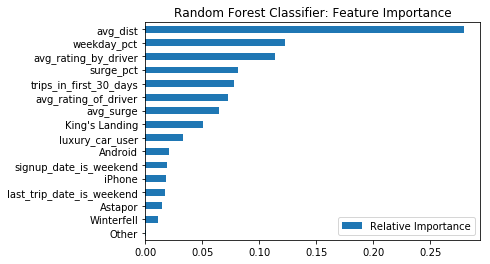

In [140]:

feat_scores = pd.DataFrame({'Relative Importance' : rf_opt.feature_importances_}, index= train2.columns)

feat_scores = feat_scores.sort_values(by='Relative Importance')
feat_scores.plot(kind='barh')
plt.title('Random Forest Classifier: Feature Importance')
plt.savefig('RF_feature.jpg',bbox_inches='tight')
plt.show()

In [165]:
#gradient boosting 
gb = GradientBoostingClassifier() 
gb_grid = {'learning_rate': [.001, 0.01,0.1],
           'max_depth': [3,4,5],
           'min_samples_leaf': [15, 20, 25],
           'max_features': ['sqrt',0.3,0.4],
           'n_estimators': [10,100,200],'random_state':[1]}
gb_model = GridSearchCV(gb,gb_grid,n_jobs=-1)
gb_model.fit(X_train,y_train)

KeyboardInterrupt: 

In [150]:
gb_best_params = gb_model.best_params_ 
# gb_model.best_score_ = accuracy = 0.78995
gb_best_params

{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 0.6,
 'min_samples_leaf': 20,
 'n_estimators': 100}

In [151]:
gb_opt = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=20, n_estimators=100,max_features=.6,max_depth=7)
gb_opt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=0.6, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=20,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

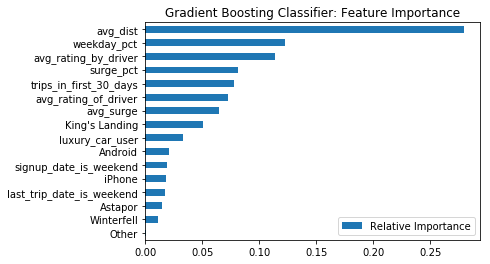

In [152]:
feat_scores_gb = pd.DataFrame({'Relative Importance' : gb_opt.feature_importances_}, index= train2.columns)

feat_scores_gb = feat_scores_gb.sort_values(by='Relative Importance')
feat_scores.plot(kind='barh')
plt.title('Gradient Boosting Classifier: Feature Importance')
plt.savefig('GB_feature.jpg',bbox_inches='tight')
plt.show()

In [174]:
from sklearn.metrics import f1_score, precision_score, recall_score
 
y_pred = gb_opt.predict(X_test) 
f1_score(y_test, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 40000]

In [ ]:
def standard_confusion_matrix(y_true, y_predict):
    # requires y_true and y_predict to be np arrays
    # returns the 
    tp = np.sum((y_true == 1) & (y_predict == 1))
    fp = np.sum((y_true == 0) & (y_predict == 1))
    fn = np.sum((y_true == 1) & (y_predict == 0))
    tn = np.sum((y_true == 0) & (y_predict == 0))
    return np.array([[tp,fp],[fn,tn]])



pred = (preds[:,1] > 0.5)*1

standard_confusion_matrix(y_test, pred)

accuracy_score(y_test,pred)